In [ ]:
import torch
import gc
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

## Load dataset

In this step, we load our French text dataset from a JSON file and prepare it for summarization. The file containing 5,598 entries, we select the 5,000 longest texts for our summarization task.

The histogram below shows the distribution of text lengths in our selected dataset. Longer texts provide a more challenging and interesting summarization task, allowing the model to demonstrate its ability to extract key information from substantial content.


      instruction_id                                        instruction  \
0  bpt6k103200m_p227  Il n'y a pas longtemps que noae avons découver...   
1  bpt6k103200m_p247  Mais, quand nous disons ce désert, c'est dans ...   
2  bpt6k103227z_p113  Et Mlle Fanny, gagnée par cetenthousiasme, rép...   
3  bpt6k103227z_p151  Eh bien, reprit là mère, nous nous lèverons de...   
4  bpt6k103227z_p254  Monsieur le docteur, dit respectueusement M. H...   

                                              output input  
0  Le lupeux est un être franchement désagréable....        
1  Ils ont pour nous le mérite de ne rien dérange...        
2  Un soir, comme les fillettes venaient de se co...        
3  Je pense que cela fera plaisir aussi à nos Par...        
4  Pendant ma classe d'histoire, il m'avait inter...        


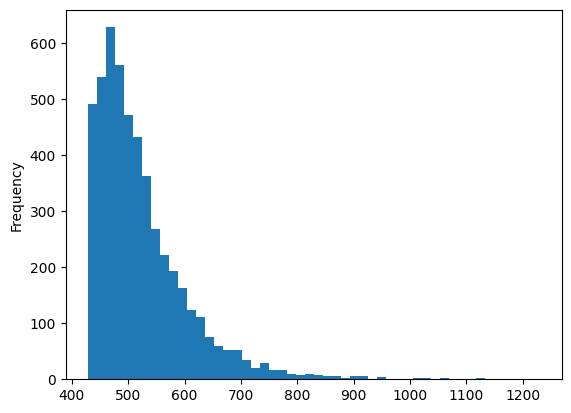

In [ ]:
df = pd.read_json("../data/instruct_fr_novel19.json")
print(df.head())

df_text = df["instruction"]
df_text = df_text.sort_values(key = lambda x: x.apply(len), ascending=False)
df_text = df_text[:5000]
df_text['length'] = df_text.apply(len)
df_text['length'].plot.hist(bins=50)

texts = df_text.to_list()

In [13]:
from huggingface_hub import notebook_login
notebook_login()

## Load the model

In the next cell, we'll load the Mistral-7B-Instruct-v0.2 model. This is a powerful 7B parameter instruction-tuned language model that can be used for various text generation tasks, including the summarization task we're working on.

We're applying 4-bit quantization through BitsAndBytes to reduce memory requirements while maintaining good performance. This configuration:
- Loads the model in 4-bit precision
- Uses float16 for compute operations
- Applies double quantization for further memory optimization
- Uses "nf4" (normalized float 4) quantization type
- Automatically places model weights on the available GPU using device_map="auto"

This approach allows us to work with this large language model in a constrainted environment.


In [14]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Testing Summarization on a Sample Document

This summarize_text function generates concise summaries from French texts using a the model. It wraps each input text in a prompt that instructs the model to create a summary with specific formatting requirements.

We tokenize these prompts and sends them to the model's device for processing. Then,  the model produces summary texts that follows the given instructions.



In [ ]:
def summarize_text(batch_texts, max_input_length=50000, max_new_tokens=500):
    prompt = [
        "Voici un texte en français :\n" 
        + text
        + "\n\n"
        + "Fais un résumé en français et seulement en français concis et informatif de 3 à 5 phrases."
        + "Le résultat doit être un texte continu sans retour à la ligne. "
        + "N'utilise ni tirets, ni numérotation, ni sauts de ligne.\n\n"
        + "Résumé :\n"
        for text in batch_texts
    ]

    inputs = tokenizer(prompt, return_tensors="pt", max_length=max_input_length, truncation=True, padding=True).to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            max_new_tokens=max_new_tokens,
            temperature = 0.4,
            num_beams=5,
            top_p=0.9,
            early_stopping=True,
            do_sample=True
        )

    input_length = inputs.input_ids.shape[1]
    summaries = [
        tokenizer.decode(summary_ids[i][input_length:], skip_special_tokens=True)
        for i in range(len(batch_texts))
    ]

    return summaries

In [6]:
i = 10
sample_texts = texts[i:i+1]
summary = summarize_text(sample_texts)

In [7]:
for text, sum in zip(sample_texts, summary):
    print(f"Text: {text}\nSummary: {sum}\n\n")

Text: DU MÊME AUTEUR: ROMANS ET NOUVELLES L'Agonie de l'Amour — La Fête Nocturne — Vous qui faites l'endormie... — Les Sangsues — Le Jeune Homme au Masque — L'Ecole des Mariages — Le Démon de la Vie — Le Reste est Silence... — Les Amours Perdues — Le Boudoir de Proserpine — L'Eventail de Crêpe — L'Incertaine — Fumées dans la Campagne — Au-dessus de la Ville — La Fin d'un beau Jour — L'Escalier d'Or — Les Profondeurs de la Mer — L'Alcyone — La Branche Morte — La Fugitive — Soleils Disparus — Lætitia — Les Barricades Mystérieuses — 0 Toi que j'eusse aimée !... — L'Amour de Cécile Fougères — L'Age d'Or — Dessins aux Trois Crayons — Le Rayon dans le Brouillard — La Balance Faussée — Sous les Oliviers de Bohême — Le Voyageur — La Grenade Mordue — Le Roman Inachevé — Les Routes du Bel Univers — Le Dernier Jour de la Création — La Capricieuse — L'Oiseau-Lyre — La Chute d'Icare — L'Egarée — Les Visiteurs — Le Vent souffle sur la Flamme — Le Pouvoir des Choses — La Comédie Féminine — Le Culte S

## Dataset annotation

We generate summaries in batch to prevent memory issues and keep a save in case of interruption.

In [ ]:
all_summaries = []
batch_size = 10
checkpoint_file = "text_summaries_checkpoint.csv"

for start in range(0, len(texts), batch_size):

    torch.cuda.empty_cache()
    gc.collect()

    batch_texts = texts[start:start + batch_size]
    batch_summaries = summarize_text(batch_texts)
    for text, summ in zip(batch_texts, batch_summaries):
        all_summaries.append({"text": text, "summary": summ})
        
    if (start // batch_size + 1) % 10 == 0:
        pd.DataFrame(all_summaries).to_csv(checkpoint_file, index=False)
        print(f"Checkpoint saved at batch {start // batch_size + 1}")

result_df = pd.DataFrame(all_summaries)
result_df.to_csv("final_texts.csv", index=False)

In [ ]:
loaded_df = pd.read_csv("../data/final_texts.csv")

print(len(loaded_df))
loaded_df.head()
loaded_df["summary"]

5000


0       Ces livres : "Bido,iiille", "Les Audiences joy...
1       Un homme nommé Suétone Lénis, un chevalier rom...
2       Léon de Rinsau, écrivain aristocratique et ana...
3       Le frère Cristoforo demande au frère gardien l...
4       Charlus veut montrer son amour pour Morel aux ...
                              ...                        
4995    Un homme attend sous la pluie pour obtenir la ...
4996    Mademoiselle Ingénio demande à l'auteur si Mad...
4997    Maurice regarde le dos de Nangès, qui part, do...
4998    Euphémin Gourbillon amuse la société en montra...
4999    Un ange seul, animé par la présence de son maî...
Name: summary, Length: 5000, dtype: object